In [1]:
# import libraries and set plotting style.  
from __future__ import print_function
import numpy as np
import pandas as pd
from scipy import linalg,sparse
from scipy.special import factorial
import matplotlib.pyplot as plt
import matplotlib.transforms
import matplotlib.patches as patches

In [2]:
# set ipython display and matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# pdf and png output
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# %matplotlib inline
%matplotlib notebook

# matplotlib style
plt.style.use('seaborn-notebook')

In [12]:
# Declare functions for base flow and finite difference derivative operators
def base_flow(y,x=1,Uinf=1,nu=1,output_full=False,Dim=2,base_type='channel',output_V=False,plot=True):
    '''
    Input:
        y: array of height of channel or flat plate
        x: location along plate
        Dim: dimension of desired output
        base_type: type of base_flow ['channel','plate']
    Output base flow for plane Poiseuille flow between two parallel plates
        U: U mean velocity (vector)
        Uy: dU/dy of mean belocity (vector)
        Uyy: d^2 U/dy^2 of mean velocity (scalar)
    '''
    if base_type=='channel':
        if Dim==2:
            _y = y[:,np.newaxis]
        elif Dim==3:
            _y = y[:,np.newaxis,np.newaxis]
        if output_full:
            U = 1.-_y**2 # make a n vector of shape (n,1) so U will broadcast with D2 and D4 correctly
            Uy = -2.*_y # dU/dy of base flow
            Uyy = -2. # d^2 U/dy^2 of base flow
        else:
            U = 1.-_y[1:-1]**2 # make a n vector of shape (n,1) so U will broadcast with D2 and D4 correctly
            Uy = -2.*_y[1:-1] # dU/dy of base flow
            Uyy = -2. # d^2 U/dy^2 of base flow
        return U,Uy,Uyy
    elif base_type=='plate':
        # assume nu=1
        y_uniform=np.linspace(y.min(),y.max(),y.size*100)
        eta=y_uniform*np.sqrt(Uinf/(2.*nu*x))
        deta=np.diff(eta) # assume uniform grid would mean deta is all the same
        # IC for blasius f'''-ff'' = 0
        # or changed to coupled first order ODE
        #     f'' = \int -f*f'' deta
        #     f'  = \int f'' deta
        #     f   = \int f' deta
        # initialize and ICs
        # make lambda function
        f_fs = lambda fs: np.array([
            -fs[2]*fs[0], # f'' = \int -f*f'' deta
            fs[0],        # f'  = \int f'' deta
            fs[1],        # f   = \int f' deta
            1.])       # eta = \int 1 deta
        fs = np.zeros((eta.size,4))
        fs[0,0] = 0.469600 # f''
        fs[0,1] = 0.       # f'
        fs[0,2] = 0.       # f
        fs[0,3] = eta[0]      # eta
        # step through eta
        #freestream=False
        for i,ideta in enumerate(deta):
            k1 = ideta*f_fs(fs[i]);
            k2 = ideta*f_fs(fs[i]+k1/2);
            k3 = ideta*f_fs(fs[i]+k2/2);
            k4 = ideta*f_fs(fs[i]+k3);
            fs[i+1] = fs[i] + (k1+(k2*2)+(k3*2)+k4)/6;
        #print('eta,f,fp,fpp = ')
        #print(fs[:,::-1])
        if output_full:
            fpp=np.interp(y,y_uniform,fs[:,0])
            fp =np.interp(y,y_uniform,fs[:,1])
            f  =np.interp(y,y_uniform,fs[:,2])
            eta=np.interp(y,y_uniform,fs[:,3])
        else:
            fpp=np.interp(y[1:-1],y_uniform[1:-1],fs[1:-1,0])
            fp =np.interp(y[1:-1],y_uniform[1:-1],fs[1:-1,1])
            f  =np.interp(y[1:-1],y_uniform[1:-1],fs[1:-1,2])
            eta=np.interp(y[1:-1],y_uniform[1:-1],fs[1:-1,3])
        fppp = np.gradient(fpp,eta)
        U  = Uinf*fp # f'
        Uy = fpp*np.sqrt(Uinf**3/(2.*nu*x))
        Uyy= fppp*(Uinf**2/(2.*nu*x))
        #Ux = fpp*(-eta/(2.*x))
        V  = np.sqrt(nu*Uinf/(2.*x))*(eta*fp - f)
        #Vy = Uinf/(2.*x) * eta*fpp
        #Vx = np.sqrt(nu*Uinf/(8.*x**3)) * (eta*fp - f - eta**2*fpp)
        if Dim==2:
            if output_full:
                # plot values
                if plot:
                    fig,ax=plt.subplots(figsize=(4,4))
                    ax.plot(U,y,'.',label='U')
                    #ax.plot(V,y,label='V')
                    ax.plot(Uy,y,'.',label='Uy')
                    ax.plot(Uyy,y,'.',label='Uyy')
                    ax.set_ylabel(r'$y$')
                    ax.legend(loc='best',numpoints=1) ;
                    fig.tight_layout()
                    fig.show()
                print('Vinf = ',V[-1],0.8604*Uinf*np.sqrt(nu/(x*Uinf)))
            else:
                if plot:
                    # plot values
                    fig,ax=plt.subplots(figsize=(4,4))
                    ax.plot(U,y[1:-1],'.',label='U')
                    ax.plot(V,y[1:-1],'.',label='V')
                    ax.plot(Uy,y[1:-1],'.',label='Uy')
                    ax.plot(Uyy,y[1:-1],'.',label='Uyy')
                    ax.set_ylabel(r'$y$')
                    ax.legend(loc='best',numpoints=1) ;
                    fig.tight_layout()
                    fig.show()
                print('Vinf = ',V[-1],0.8604*Uinf*np.sqrt(nu/(x*Uinf)))

            if output_V:
                return U,V
            else:
                return U[:,np.newaxis],Uy[:,np.newaxis], Uyy[:,np.newaxis]
        elif Dim==3:
            return U[:,np.newaxis,np.newaxis],Uy[:,np.newaxis,np.newaxis], Uyy[:,np.newaxis,np.newaxis]
def get_D_Coeffs(s,d=2):
    '''
    Solve arbitrary stencil points s of length N with order of derivatives d<N
    can be obtained from equation on MIT website
    http://web.media.mit.edu/~crtaylor/calculator.html
    where the accuracy is determined as the usual form O(h^(N-d))
    
    Inputs:
        s: array like input of stencil points e.g. np.array([-3,-2,-1,0,1])
        d: order of desired derivative
    '''
    # let's solve an Ax=b problem
    N=s.size # stencil length
    A=[]
    for i in range(N):
        A.append(s**i)
    b=np.zeros(N)
    b[d] = factorial(d)
    x = np.linalg.solve(np.matrix(A),b)
    return x
def set_D(y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    '''
    Input:
        y: array of y values of channel
        order: order of accuracy desired (assuming even e.g. 2,4,6,...)
        d: dth derivative
    Output:
        D: (n-2 by n) dth derivative of order O(h^order) assuming uniform y spacing
    '''
    h = y[1]-y[0] # uniform spacing
    if not uniform:
        xi=np.linspace(0,1,y.size)
        h=xi[1] - xi[0]
    n = y.size
    ones=np.ones(n)
    I = np.eye(n)
    # get coefficients for main diagonals
    N=order+d # how many pts needed for order of accuracy
    if N>n:
        raise ValueError('You need more points in your domain, you need %i pts and you only gave %i'%(N,n))
    Nm1=N-1 # how many pts needed if using central difference is equal to N-1
    if (d % 2 != 0): # if odd derivative
        Nm1+=1 # add one more point to central, to count the i=0 0 coefficient
    # stencil and get Coeffs for diagonals
    s = np.arange(Nm1)-int((Nm1-1)/2) # stencil for central diff of order
    smax=s[-1] # right most stencil used (positive range)
    Coeffs = get_D_Coeffs(s,d=d)
    # loop over s and add coefficient matrices to D
    D = np.zeros_like(I)
    si = np.nditer(s,('c_index',))
    while not si.finished:
        i = si.index
        if si[0]==0:
            diag_to_add = np.diag(Coeffs[i] * ones,k=si[0])
        else:
            diag_to_add = np.diag(Coeffs[i] * ones[:-abs(si[0])],k=si[0])

        D += diag_to_add
        if periodic:
            if si[0]>0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]-n)
            elif si[0]<0:
                diag_to_add = np.diag(Coeffs[i]*ones[:abs(si[0])],k=si[0]+n)
            if si[0]!=0:
                D += diag_to_add
                
        si.iternext()
    if not periodic:
        # alter BC so we don't go out of range on bottom of channel
        for i in range(0,smax):
            # for ith row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = np.arange(Nm1-1)-i # stencil for shifted diff of order-1
                else:
                    s = np.arange(Nm1)-i # stencil for shifted diff of order-1
            else:
                s = np.arange(N)-i # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[i,:] = 0. # set row to zero
            D[i,s+i] = Coeffs # set row to have proper coefficients

            # for -ith-1 row, set proper stencil coefficients
            if reduce_wall_order:
                if (d%2!=0): # if odd derivative
                    s = -(np.arange(Nm1-1)-i) # stencil for shifted diff of order-1
                else:
                    s = -(np.arange(Nm1)-i) # stencil for shifted diff of order-1
            else:
                s = -(np.arange(N)-i) # stencil for shifted diff of order
            Coeffs = get_D_Coeffs(s,d=d)
            D[-i-1,:] = 0. # set row to zero
            D[-i-1,s-i-1] = Coeffs # set row to have proper coefficients

    if output_full:
        D = (1./(h**d)) * D # do return the full matrix
    else:
        D = (1./(h**d)) * D[1:-1,:] # do not return the top or bottom row
    if not uniform:
        D = map_D(D,y,order=order,d=d,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=uniform)
    return D 
def map_D(D,y,order=2,d=2,reduce_wall_order=True,output_full=False,periodic=False,uniform=True):
    if not uniform:
        xi=np.linspace(0,1,y.size)
        if d==1: # if 1st derivative operator d(.)/dy = d(.)/dxi * dxi/dy
            dydxi = D@y # matrix multiply in python3
            dxidy = 1./dydxi # element wise invert
            return D*dxidy[:,np.newaxis] # d(.)/dy = d(.)/dxi * dxi/dy
        elif d==2: # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
            D1=set_D(xi,order=order,d=1,reduce_wall_order=reduce_wall_order,output_full=output_full,periodic=periodic,uniform=True)
            dydxi = D1@y
            dxidy = 1./dydxi # element wise invert
            #d2ydxi2 = D@y # d^2y/dxi^2
            #d2xidy2 = 1./d2ydxi2 # d^2xi/dy^2 = 1./(d^2y/dxi^2)
            d2xidy2 = -(D@y)*(dxidy)**3
            #print('d2xidy2 = ',d2xidy2)
            return (D*(dxidy[:,np.newaxis]**2)) + (D1*d2xidy2[:,np.newaxis])  # d^2()/dy^2 = d^2()/dxi^2 (dxi/dy)^2 + d()/dxi d^2xi/dy^2
        else:
            print('Cannot do this order of derivative with non-uniform mesh.  your input order of derivative = ',d)
    else:
        return D
def set_D_for_zi(y,z,zi,output_full=False,uniform=True,**kwargs):
    '''
    set a 3D matrix of derivative operators for  Dy and Dz of the proper order
    
    Inputs:
        y: y spatial array
        z: z spatial array
        zi: z index currently
        order: order of accuracy desired in derivatives
        **kwargs: other keyword arguments for set_D function
    Returns:
        Dy: (3D matrix of all y values, at particular zi index)
        Dz: (3D matrix of all y values, at particular zi index)
    '''
    ny=y.size
    nz=z.size
    # calc derivatives for y
    Dy = set_D(y,output_full=output_full,uniform=uniform,**kwargs) 
    # set zero matrix
    zero = np.zeros(Dy.shape+(nz,))
    Dy_all = np.copy(zero)
    Dz_all = np.copy(zero)
    # set derivatives for y
    #hy=y[1]-y[0]
    Dy_all[:,:,zi] = Dy
    # calculate derivatives for z
    #hz=z[1]-z[0]
    Dz = set_D(z,periodic=True,output_full=True,**kwargs)[zi]
    # set derivatives into bigger matrix to be returned
    for i in range(ny-2):
        Dz_all[i,i+1,:] = Dz
    return Dy_all,Dz_all
def geometric_stretch(ymin=0,ymax=1,stretching_factor=1.1,ny=128,OSS_and_NALU=True):
    y=np.zeros(ny)
    y[0]=ymin
    y[-1]=ymax
    print('ymax = ',ymax)
    def Rpowi(R,i):
        out=0
        for j in range(i+1):
            out+=R**j
        return out
    dy0=(ymax-ymin)/(Rpowi(stretching_factor,ny-2))
    print('dy0 = ',dy0)
    for i in range(ny-2):
        y[i+1] = ymin+dy0*Rpowi(stretching_factor,i)
        #print('y[',i+1,'] = ',y[i+1])
    
    # now output for y_NALU
    if OSS_and_NALU:
        y_NALU=[ymin]
        i=0
        while y_NALU[i]<=ymax*6: # output something 6 times larger than the input ymax
            y_NALU.append(ymin+dy0*Rpowi(stretching_factor,i))
            i+=1
        return y,np.array(y_NALU)
    else:
        return y,y

In [4]:
# functions for plotting eigenfunctions on branches
def add_evec_y_branch(ax,n,y,eig_Ai,eig,evec,branch_title,eig_type=r'\omega'):
    ax.set_title(branch_title + r' $'+eig_type+' = %.1e+%.1ej$'%(eig[eig_Ai].real,eig[eig_Ai].imag))
    ax.plot( np.abs(evec[:,eig_Ai]),
        y,
        label=r'abs')
    ax.plot( evec[:,eig_Ai].real,
        y,
        label=r'real')
    ax.plot( evec[:,eig_Ai].imag,
        y,
        label=r'imag')
def plot_evec_a_branch(y,n,Ai,eig,evec,title='',eig_type=r'\omega'):
    # get indices of branches
    eig_A_i = np.nanargmin((np.abs(eig-Ai)))
    # open figure and plot the three branches
    fig,ax=plt.subplots(nrows=1,ncols=1,sharey=True,figsize=(3,3))
    add_evec_y_branch(ax,n,y,eig_A_i,eig,evec,'A',eig_type=eig_type)
    ax.legend(loc='best',frameon=False,numpoints=1)
    ax.set_xlabel(title)
    ax.set_ylabel(r'$y$')
    fig.tight_layout()
    plt.show()
def plot_evec_all_branches(y,n,Ai,Pi,Si,eig,evec,title=''):
    # get indices of branches
    eig_A_i = np.nanargmin((np.abs(eig-Ai)))
    eig_P_i = np.nanargmin((np.abs(eig-Pi)))
    eig_S_i = np.nanargmin((np.abs(eig-Si)))
    # open figure and plot the three branches
    fig,ax=plt.subplots(nrows=3,ncols=1,sharey=True,figsize=(3,7))
    add_evec_y_branch(ax[0],n,y,eig_A_i,eig,evec,'A')
    add_evec_y_branch(ax[1],n,y,eig_P_i,eig,evec,'P')
    add_evec_y_branch(ax[2],n,y,eig_S_i,eig,evec,'S')
    ax[0].legend(loc='best',frameon=False,numpoints=1)
    #ax[1].legend(loc='best',frameon=False,numpoints=1)
    #ax[2].legend(loc='best',frameon=False,numpoints=1)
    ax[2].set_xlabel(title)
    [axi.set_ylabel(r'$y$') for axi in ax]
    fig.tight_layout()
    plt.show()

In [5]:
# function for calc and plotting mesh convergence
def RSSE_n(solver,c,order=2,iplot=False,n_all=[np.linspace(-1,1,51),np.linspace(-1,1,61)],z=False,**kwargs):
    RSSE_n=[]
    for n in n_all:
        # solve eigenvalue problem
        if not z:
            #y=np.linspace(-1,1,n)
            eig,evec,eig_i = solver(   
                y=n,
                order=order,
                iplot=iplot,
                **kwargs)
        elif z:
            #y=np.linspace(-1,1,n[0])
            #z=np.linspace(-1,1,n[1])
            eig,evec,eig_i = solver(   
                y=n[0],
                z=n[1],
                order=order,
                iplot=iplot,
                **kwargs)
            
        eig_ci=[]
        for ci in c:
            eig_ci.append(np.nanargmin(np.abs(eig-ci)))
            

        # plot against table
        if iplot:
            fig=plt.figure() 
            ax=plt.subplot(111)
            ax.plot(c.real,c.imag,'s',label='c Schmid')
            ax.plot(eig[eig_ci].real,eig[eig_ci].imag,'.',label='Finit Difference')
            ax.set_xlabel(r'$\omega_r$')
            ax.set_ylabel(r'$\omega_i$')
            ax.legend(loc='best',numpoints=1)
            fig.tight_layout()
            plt.show()

        # calc error as root sum squared
        RSSE= np.sqrt(np.sum(np.abs(eig[eig_ci] - c)**2))
        RSSE_n.append(RSSE)
        if z==False:
            print('for n = %i, order = %i, then RSSE = %.3e'%(n,order,RSSE))
        elif z:
            print('for ny = %i, nz = %i, order = %i, then RSSE = %.3e'%(n[0].size,n[1].size,order,RSSE))
    return (eig,eig_ci,n_all,RSSE_n)
def calc_and_plot_eigs_RSSE(solver,c,axdiff=None,axcon=None,
                            color='b',order=2,n_all=[101,161],z=False,**kwargs):
    # calc eigenvalues of order
    eig,eig_ci,n_all,RSSE_n2 = RSSE_n(solver,c,order=order,n_all=n_all,z=z,**kwargs)
    # plot eigenvalues
    axdiff.plot(eig[eig_ci].real,eig[eig_ci].imag
                ,'.',color=color,label=r'Finite Difference $O(h^{%i})$'%order)
    # plot error convergence
    if z==False:
        n_all_sizes = [n_all[i].size for i in range(len(n_all))]
        axcon.loglog(n_all_sizes,RSSE_n2
                     ,'o',color=color,label=r'Finite Difference $O(h^{%i})$'%order)
    elif z:
        n_all_sizes = [n_all[i][0].size for i in range(len(n_all))]
        axcon.loglog(n_all_sizes,RSSE_n2
                     ,'o',color=color,label=r'Finite Difference $O(h^{%i})$'%order)
    # return the highest error term, to be used to plotting convergence expectation
    return RSSE_n2[0] 
def add_legend_outside(fig,ax, x0=1,y0=1, direction = "h", padpoints = 3,**kwargs):
    otrans = ax.figure.transFigure
    t = ax.legend(bbox_to_anchor=(x0,y0), loc=1, bbox_transform=otrans,**kwargs)
    plt.tight_layout()
    ax.figure.canvas.draw()
    plt.tight_layout()
    ppar = [0,-padpoints/72.] if direction == "v" else [-padpoints/72.,0] 
    trans2=matplotlib.transforms.ScaledTranslation(ppar[0],ppar[1],fig.dpi_scale_trans)+\
             ax.figure.transFigure.inverted() 
    tbox = t.get_window_extent().transformed(trans2 )
    bbox = ax.get_position()
    if direction=="v":
        ax.set_position([bbox.x0, bbox.y0,bbox.width, tbox.y0-bbox.y0]) 
    else:
        ax.set_position([bbox.x0, bbox.y0,tbox.x0-bbox.x0, bbox.height])
def plot_mesh_convergence(solver,c,orders=[2,4,],n_all=[101,161],z=False,**kwargs):
    
    fig1=plt.figure(figsize=(6,4))  # plot for finite diffs
    axdiff=plt.subplot(111)
    axdiff.plot(c.real,c.imag,'s',label='Schmid')
    axdiff.set_xlabel(r'$\omega_r$')
    axdiff.set_ylabel(r'$\omega_i$')

    fig2=plt.figure(figsize=(6,4)) 
    axcon=plt.subplot(111)
    axcon.set_xlabel(r'$n$')
    axcon.set_ylabel(r'$RSSE$')
    axcon.set_prop_cycle(None)

    #n_all = [81,91,101,111,121,162]
    for orderi in orders:
        colori = next(axcon._get_lines.prop_cycler)
        RSSE_n2 = calc_and_plot_eigs_RSSE(solver,c,axdiff=axdiff,axcon=axcon
                                          ,color=colori['color'],order=orderi,n_all=n_all,z=z,**kwargs)
        if z==False:
            axcon.loglog([n_all[0].size,n_all[0].size*2],[RSSE_n2,RSSE_n2/2**orderi],
                         color=colori['color'],label=r'$O(h^{%i})$ line'%orderi)
        elif z:
            axcon.loglog([n_all[0][0].size,n_all[0][0].size*2],[RSSE_n2,RSSE_n2/2**orderi],
                         color=colori['color'],label=r'$O(h^{%i})$ line'%orderi)
    add_legend_outside(fig1,axdiff)
    add_legend_outside(fig2,axcon)
    plt.show()

In [6]:
# functions for primitive formulation in spatial dimension $\alpha$ u,v,w,P
def set_BCs_primitive_spatial_zi(y, z,zi,Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons, omega,order=2,large_multiple=6e1):
    '''
    Set boundary condition values to As, Bs
    Modifies the (n-2 X n) matrices to be (n X n)
    Sets first/last row of Aos, Bos to have the BC v'=0 at walls
    Adds first/last rows to all matrices to have v=eta=0 at walls
    
    Inputs:
        y: y spactial array 
        Aus: List of [Auu,Auav,Auv,Auaw,Auw,Aup] 3D for each z
        Bus: List of [Buu,Buav,Buv,Buaw,Buw,Bup] 3D for each z
        Avs: List of [Avu,Avav,Avv,Avaw,Avw,Avp] 3D for each z
        Bvs: List of [Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp] 3D for each z
        Aws: List of [Awu,Awav,Awv,Awaw,Aww,Awp] 3D for each z
        Bws: List of [Bwu,Bwav,Bwv,Bwaw,Bww,Bwp] 3D for each z
        Acons: List of [Aconau,Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp] 3D for each z
        Bcons: List of [Bconau,Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp] 3D for each z
        order: order of derivative (O(h^order))
        large_multiple: used to set RHS to nonzero and kill spurious eigenmodes
    '''
    #h=y[1]-y[0]
    # v=0 at walls
    # rows to add to As and Bs at top and bottom
    zero_plane = np.zeros_like(Aus[0][0,:,:][np.newaxis,:,:])
    v0_at_bottom = np.copy(zero_plane)
    v0_at_bottom[0,0,zi] = 1.
    v0_at_top = np.copy(zero_plane)
    v0_at_top[0,-1,zi] = 1.
    # add them to As and Bs
    # for Aus Bus u=0
    for i in range(len(Aus)):
        if i==0:
            Aus[i] = np.concatenate((v0_at_bottom,Aus[i],v0_at_top),axis=0)
            Bus[i] = np.concatenate((large_multiple*v0_at_bottom,Bus[i],large_multiple*v0_at_top),axis=0)
        else:
            Aus[i] = np.concatenate((zero_plane,Aus[i],zero_plane),axis=0)
            Bus[i] = np.concatenate((zero_plane,Bus[i],zero_plane),axis=0)
    # for Avs Bvs v=0
    for i in range(len(Avs)):
        if i==2:
            Avs[i] = np.concatenate((v0_at_bottom,Avs[i],v0_at_top),axis=0)
            Bvs[i] = np.concatenate((large_multiple*v0_at_bottom,Bvs[i],large_multiple*v0_at_top),axis=0)
        else:
            Avs[i] = np.concatenate((zero_plane,Avs[i],zero_plane),axis=0)
            Bvs[i] = np.concatenate((zero_plane,Bvs[i],zero_plane),axis=0)
    # for Aws Bws w=0
    for i in range(len(Aws)):
        if i==4:
            Aws[i] = np.concatenate((v0_at_bottom,Aws[i],v0_at_top),axis=0)
            Bws[i] = np.concatenate((large_multiple*v0_at_bottom,Bws[i],large_multiple*v0_at_top),axis=0)
        else:
            Aws[i] = np.concatenate((zero_plane,Aws[i],zero_plane),axis=0)
            Bws[i] = np.concatenate((zero_plane,Bws[i],zero_plane),axis=0)
    return (Aus,Bus,Avs, Bvs, Aws, Bws, Acons, Bcons)
def set_A_and_B_primitive_spatial_zi(y,z,zi,omega=0.3,Re=2000.,order=2,large_multiple=6e1,base_type='channel',x=1,Uinf=1,nu=1,uniform=True):
    '''
    Set A and B matrix for stated eigenvalue equation Aq=\omega Bq
    Input:
        y: array of y values of channel
        omega=1 : omega value for eigenvalue equation for channel flow
        Re=2000. : Reynolds number for flow
        order: order of accuracy of finite difference derivatives to use
    Output:
        A: matrix for LHS of eigenvalue equation
        B: matrix for RHS of eigenvalue equation
    '''
    #hy=y[1]-y[0] # uniform spacing is assumed
    #hz=z[1]-z[0] # uniform spacing is assumed
    ny = y.size
    nz = z.size
    
    iomega = 1.j*omega
    iRe = 1.j * Re
    
    # identity matrix
    I = np.zeros((ny,ny,nz))
    I[:,:,zi] = np.eye(ny)
    Im2=I[1:-1,:,:] # skip first and last rows (at walls)
    Im20=0.*Im2
    I0 = 0.*I
    # base flow
    U,Uy,Uyy = base_flow(y,Dim=3,x=x,nu=nu,Uinf=Uinf,base_type=base_type)
    
    # calculate derivatives
    Dy,Dz = set_D_for_zi(y,z,zi,d=1,order=order,uniform=uniform)
    Dy_full,Dz_full = set_D_for_zi(y,z,zi,d=1,order=order,output_full=True,uniform=uniform)
    Dyy,Dzz = set_D_for_zi(y,z,zi,d=2,order=order,uniform=uniform)
    
    # for Orr-Sommerfeld eq. of the form
    a = -iomega*Im2 + (-1./Re)*Dyy + (-1./Re)*Dzz
    iU = (1.j * U* Im2)
    # set constants and Au Bu
    Auu = a
    Auav= Im20
    Auv = Uy * Im2
    Auaw= Im20
    Auw = Im20
    Aup = Im20
    Aus = [Auu,Auav,Auv,Auaw,Auw,Aup]
    Buu = -iU
    Buav= Im20
    Buv = (-1.j/Re) * Dy
    Buaw= Im20
    Buw = (-1.j/Re) * Dz
    Bup = -1.j*Im2
    Bus = [Buu,Buav,Buv,Buaw,Buw,Bup]
    
    
    # for constants and Av Bv
    Avu = Im20
    Avav= Im20
    Avv = a
    Avaw= Im20
    Avw = Im20
    Avp = Dy
    Avs = [Avu,Avav,Avv,Avaw,Avw,Avp]
    Bvu = Im20
    Bvav= -(1./Re)*Im2
    Bvv = -iU
    Bvaw= Im20
    Bvw = Im20
    Bvp = Im20
    Bvs = [Bvu,Bvav,Bvv,Bvaw,Bvw,Bvp]
    
    # for constants and Aw Bw
    Awu = Im20
    Awav= Im20
    Awv = Im20
    Awaw= Im20
    Aww = a
    Awp = Dz
    Aws = [Awu,Awav,Awv,Awaw,Aww,Awp]
    Bwu = Im20
    Bwav= Im20
    Bwv = Im20
    Bwaw= -(1./Re)*Im2
    Bww = -iU
    Bwp = Im20
    Bws = [Bwu,Bwav,Bwv,Bwaw,Bww,Bwp]
    
    # for constants and Acon Bcon
    Aconu = I0
    Aconav= I0
    Aconv = Dy_full
    Aconaw= I0
    Aconw = Dz_full
    Aconp = I0
    Acons = [Aconu,Aconav,Aconv,Aconaw,Aconw,Aconp]
    Bconu = -1.j*I
    Bconav= I0
    Bconv = I0
    Bconaw= I0
    Bconw = I0
    Bconp = I0
    Bcons = [Bconu,Bconav,Bconv,Bconaw,Bconw,Bconp]
    
    # BCs
    Aus,Bus,Avs,Bvs,Aws,Bws,Acons,Bcons = set_BCs_primitive_spatial_zi(
        y, z,zi,Aus, Bus, Avs, Bvs, Aws, Bws, Acons, Bcons,  
        omega,order=order,large_multiple=large_multiple)
    
    #combine to A and B for combined eqs.
    A = np.concatenate((
            np.concatenate(Aus,axis=1),                   # u-mom
            np.concatenate(Avs,axis=1),                   # v-mom
            np.concatenate([I0,I,I0,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Aws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I,I0,I0],axis=1), # aw=a*w
            np.concatenate(Acons,axis=1))                 # continuity
        ,axis=0)
    B = np.concatenate((
            np.concatenate(Bus,axis=1),                   # u-mom
            np.concatenate(Bvs,axis=1),                   # v-mom
            np.concatenate([I0,I0,I,I0,I0,I0],axis=1), # av=a*v
            np.concatenate(Bws,axis=1),                   # w-mom
            np.concatenate([I0,I0,I0,I0,I,I0],axis=1), # aw=a*w
            np.concatenate(Bcons,axis=1))                 # continuity
        ,axis=0)
    return (A,B)
def set_A_and_B_primitive_spatial_z(y,z,omega=1,Re=2000.,order=2,large_multiple=6e1,base_type='channel',x=1,Uinf=1,nu=1,uniform=True):
    As=[]
    Bs=[]
    for i,zi in enumerate(z):
        Ai,Bi = set_A_and_B_primitive_spatial_zi(y,z,i,omega=omega,Re=Re,order=order,large_multiple=large_multiple,x=x,Uinf=Uinf,nu=nu,base_type=base_type,uniform=uniform)
        As.append(Ai)
        Bs.append(Bi)
    # stack for all z
    A_3D = np.concatenate(As,axis=0)
    B_3D = np.concatenate(Bs,axis=0)
    # make 3D to 2D conversion
    #A_2D = unblockshaped(A_3D,A_3D.shape[1],-1)
    #B_2D = unblockshaped(B_3D,B_3D.shape[1],-1)
    A_2D = np.concatenate([A_3D[:,:,i] for i,value in enumerate(A_3D[0,0,:])],axis=1)
    B_2D = np.concatenate([B_3D[:,:,i] for i,value in enumerate(B_3D[0,0,:])],axis=1)
    return A_2D,B_2D
def set_and_solve_eig_primitive_spatial_z(y,z,iBCs=True,iplot=True,input_line=True,order=2,**kwargs):
    '''
    Inputs:
        ny=201:   number of pts in spatial y for finite difference scheme
        nz=6:   number of pts in spatial z for finite difference scheme
        ymin,ymax:  min and max of spatial y dimension domain
        zmin,zmax:  min and max of spatial z dimension domain
        order=2:  order of accuracy O(h^order)
        iBCs:  check BCs if set to True (True by default)
        iplot:  plot the eigenvalue spectrum (True by default)
        input_line:  print the inputs if True
        **kwargs: inputs for set_A_and_B and set_D and set_BCs
    Returns:
        eig:     eigenvalues of the equation
        evec:    eigenvectors of the equation
        eig_i:   index for eig and evec for max(eig) to smallest(eig) by using np.sort()
    '''
    if input_line:
        print('inputs:')
        print('    order=%i'%(order),end='')
        for k in kwargs.items():
            print(k,end='')
        print('')
    
    # create y
    #y = np.linspace(ymin,ymax,ny)
    #z = np.linspace(zmin,zmax,nz)
    ny=y.size
    nz=z.size
    # solve eigenvalue problem
    A,B = set_A_and_B_primitive_spatial_z(y,z,order=order,**kwargs)
    eig,evec = linalg.eig(A,b=B)
    
    # sort in order of decending eigenvalues using argsort and print max,min,nans,inf
    eig_i = eig.imag.argsort()[::-1]   
    if iBCs:
        print( 'check max and min eig')
        print( '   ',eig[eig!=np.inf][np.nanargmax(np.abs(eig[eig!=np.inf]))])
        print( '   ',eig[eig!=np.inf][np.nanargmin(np.abs(eig[eig!=np.inf]))])
        print( 'check isnan and isinf')
        print( '   ',eig[np.isnan(eig)])
        print( '   ',eig[np.isinf(eig)])

        # check BCs
        #print('check BCs u=v=w=0')
        # check values at walls
        u = np.stack([evec[(i*6+0)*ny:(i*6+1)*ny,:] for i,zi in enumerate(z)],axis=-1)
        #av= np.stack([evec[(i*6+1)*ny:(i*6+2)*ny,:] for i,zi in enumerate(z)],axis=-1)
        v = np.stack([evec[(i*6+2)*ny:(i*6+3)*ny,:] for i,zi in enumerate(z)],axis=-1)
        #aw= np.stack([evec[(i*6+3)*ny:(i*6+4)*ny,:] for i,zi in enumerate(z)],axis=-1)
        w = np.stack([evec[(i*6+4)*ny:(i*6+5)*ny,:] for i,zi in enumerate(z)],axis=-1)
        #P = np.stack([evec[(i*6+5)*ny:(i*6+6)*ny,:] for i,zi in enumerate(z)],axis=-1)
        
        BadBCun1 = u[0,:,:]!=0
        BadBCup1 = u[-1,:,:]!=0
        BadBCvn1 = v[0,:,:]!=0
        BadBCvp1 = v[-1,:,:]!=0
        BadBCwn1 = w[0,:,:]!=0
        BadBCwp1 = w[-1,:,:]!=0
        #BadBCpn1 = evec[3*n,:]!=0
        #BadBCpp1 = evec[4*n-1,:]!=0

        print( '  bad boundary condition eigenfunctions satisfying u=0')
        print( '   ',u[0,BadBCun1],'with associated eig-value of',eig[BadBCun1[:,0]],' u(y=-1 )=0')
        print( '   ',u[-1,BadBCup1],'with associated eig-value of',eig[BadBCup1[:,0]],' u(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying v=0')
        print( '   ',v[0,BadBCvn1],'with associated eig-value of',eig[BadBCvn1[:,0]],' v(y=-1 )=0')
        print( '   ',v[-1,BadBCvp1],'with associated eig-value of',eig[BadBCvp1[:,0]],' v(y=1 )=0')
        print( '  bad boundary condition eigenfunctions satisfying w=0')
        print( '   ',w[0,BadBCwn1],'with associated eig-value of',eig[BadBCwn1[:,0]],' w(y=-1 )=0')
        print( '   ',w[-1,BadBCwp1],'with associated eig-value of',eig[BadBCwp1[:,0]],' w(y=1 )=0')
        #print( '  bad boundary condition eigenfunctions satisfying P=0')
        #print( '   ',evec[3*n,BadBCpn1],'with associated eig-value of',eig[BadBCpn1],' p(y=-1 )=0')
        #print( '   ',evec[4*n-1,BadBCpp1],'with associated eig-value of',eig[BadBCpp1],' p(y=1 )=0')
        
        # now check continuity ialpha*u + D1*v + ibeta*w = 0
        #ialpha=1.j*eig[np.newaxis,:]
        #ibeta=1.j*kwargs['beta']
        #D1_mat = np.matrix(set_D(y,order=order,d=1,output_full=True))
        #v_mat = np.matrix(v)
 
        #continuity = ialpha*u + np.array(D1_mat*v_mat) + ibeta*w
        #Badcont = continuity!=0
        #print( '  bad eigenfunctions satisfying continuity=0')
        #print( '   ',continuity[Badcont],'with associated eig-value of',eig[Badcont[0]])
        #fig=plt.figure(figsize=(5,4))
        #plt.title('contintuity=0')
        #for i,conti in enumerate(np.transpose(continuity)):
        #    plt.plot(conti,y,'o',label=r'$\omega=%.1e+%.1ej$'%(eig[i].real,eig[i].imag))
        #plt.ylabel(r'$y$')
        #plt.xlabel(r'continuity')
        #fig.tight_layout()
        
    if iplot:
        # plot Orr-Sommerfeld-Squire spectrum
        #fig=plt.figure(figsize=(4,4))
        #ax=plt.subplot(111)
        fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,4))
        ax[0].plot(eig.real,eig.imag,'b.')
        ax[0].axis([-0.5,1.1,-20,10])
        ax[0].axhspan(-20,0,facecolor='k',alpha=0.25)
        ax[0].axvline(0,color='k',alpha=0.5)
        ax[0].axhline(0,color='k',alpha=0.5)
        ax[0].add_patch( 
            patches.Rectangle(
                (0.2, 00.1),
                0.9,
                0.9,
                edgecolor='black',
                fill=False      # remove background 
                ) 
            )
        ax[1].plot(eig.real,eig.imag,'b.')
        ax[1].axis([0.2,1.1,-0.1,0.8])
        ax[1].axhspan(-0.1,0,facecolor='k',alpha=0.25)
        ax[0].set_ylabel(r'$\alpha_i$')
        for axi in ax:
            axi.set_xlabel(r'$\alpha_r$')
            axi.set_title('eigenvalues')
        fig.tight_layout()
        plt.show()
    return eig,evec,eig_i#,A,B
def save_evec_a_branch(y,z,Ai,eig,evec,filename='output'):
    eig_A_i = np.nanargmin((np.abs(eig-Ai)))
    ycomplex=y+0j
    zcomplex=z+0j
    ycomplex.tofile(filename+'_y.dat')
    zcomplex.tofile(filename+'_z.dat')
    eig[eig_A_i].tofile(filename+'_eig.dat')
    print('saved eig=',eig[eig_A_i])
    evec[:,eig_A_i].tofile(filename+'_evec.dat')
    print('saved evec=',evec[:,eig_A_i])
    np.savetxt(filename+'_y.txt',ycomplex)
    np.savetxt(filename+'_z.txt',zcomplex)
    np.savetxt(filename+'_eig.txt',[eig[eig_A_i],])
    np.savetxt(filename+'_evec.txt',evec[:,eig_A_i])

## Now solve $\mathbf{Aq} = \alpha \mathbf{Bq}$ using wavelike solution $u=\hat{u}(y,z) \exp (i (-\omega t + \alpha x))$ and primitive formulation
Starting with the fluctuation equations: 
\begin{aligned}
\frac{\partial u}{\partial t} + U \frac{\partial u}{\partial x} + v U' &= -\frac{\partial P}{\partial x} + \frac{1}{Re} \nabla^2 u\\
\frac{\partial v}{\partial t} + U \frac{\partial v}{\partial x} &= -\frac{\partial P}{\partial y} + \frac{1}{Re} \nabla^2 v\\
\frac{\partial w}{\partial t} + U \frac{\partial w}{\partial x} &= -\frac{\partial P}{\partial z} + \frac{1}{Re} \nabla^2 w\\
\frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} + \frac{\partial w}{\partial z} &= 0\\
\end{aligned}
We plug in the wavelike solution $u=\hat{u}(y,z) \exp (i (-\omega t + \alpha x))$ and obtain the following equations
\begin{aligned}
(-i \omega - \frac{1}{Re}(\partial_y^2 + \partial_z^2))\hat{u} + U' \hat{v} &= \alpha (-i \hat{P} - \frac{i}{Re}(\partial_y \hat{v} + \partial_z \hat{w}) - iU  \hat{u})\\
(-i \omega - \frac{1}{Re}(\partial_y^2 + \partial_z^2))\hat{v} + \partial_y \hat{P}  &= \alpha (- \frac{1}{Re}(\alpha \hat{v}) -  iU \hat{v})\\
(\alpha \hat{v}) &= \alpha \cdot \hat{v}\\
(-i \omega - \frac{1}{Re}(\partial_y^2 + \partial_z^2))\hat{w} + \partial_z \hat{P}  &= \alpha (- \frac{1}{Re}(\alpha \hat{w}) -  iU \hat{w})\\
(\alpha \hat{w}) &= \alpha \cdot \hat{w}\\
\partial_y \hat{v} + \partial_z \hat{w} &= \alpha (-i \hat{u})\\
\end{aligned}
Where we have
\begin{aligned}
\mathbf{z}_i=
\begin{bmatrix}
\hat{u}\\
\alpha \hat{v}\\
\hat{v}\\
\alpha \hat{w}\\
\hat{w}\\
\hat{P}
\end{bmatrix}_{z=z(i)}
\textrm{ and }
& \mathbf{q} = \begin{bmatrix}
\mathbf{z}_1\\
\mathbf{z}_2\\
\vdots \\
\mathbf{z}_{nz - 1}\\
\mathbf{z}_{nz}\\
\end{bmatrix}\\
\end{aligned}
To solve the spatial eigenvalue problem $\mathbf{\mathcal{A}q} = \alpha \mathbf{\mathcal{B}q}$

# Run flat plate case

omega =  0.059168
Rex =  160000.0
x= 232.5581395348837
nu= 0.0014534883720930232
ymax =  69.06624374380232
dy0 =  0.05930511603119933
y_NALU.max() =  69.06624374380232
y_NALU.size  =  256


<IPython.core.display.Javascript object>


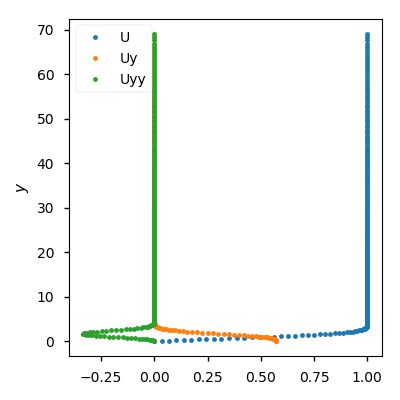

Vinf =  0.0021509845896779895 0.002151
y[U<0.99].size =  40


In [27]:
# run primitive formulation in spatial dimension $\alpha$ with spatial z for flat plate flow
ny=256#128#91
stretching_factor=1.01
nz=6
F=86. #260. # F=10^6 omega nu/Uinf^2 = 10^6 omega/Re_delta
Re_delta=400.*1.72 #1000.

# calculate some inputs
omega=F*Re_delta/10**6
print('omega = ',omega)
nu=1./Re_delta
Rex=(Re_delta/1.72)**2
print('Rex = ',Rex)
Uinf=1.
x=Rex*nu/Uinf
print('x=',x)
print('nu=',nu)

# calculate y
# geometric stretching y
y,y_NALU=geometric_stretch(
    ymin=0,
    ymax=np.sqrt(2*x*nu/Uinf)*14*6, # 14=4 boundary layers thick, and 6=> 24 boundary layers
    stretching_factor=stretching_factor,
    ny=ny,
    OSS_and_NALU=False)
print('y_NALU.max() = ',y_NALU.max())
print('y_NALU.size  = ',y_NALU.size)
# tanh stretching y
#delta=2.6
#y=np.linspace(0,1,ny)*np.sqrt(2*x*nu/Uinf)*14
#y=(1.+(np.tanh(delta*(y/y.max() - 1)))/(np.tanh(delta)))*y.max()
# uniform z
z=np.linspace(0,1,nz)

# inputs for solving the problem
kwargs={
    'y':y,
    'z':z,
    'iBCs':True,
    'iplot':True,
    'omega':omega, # compare to Schmid textbook
    'Re':Re_delta, # compare to Schmid textbook
    'x':x,
    'Uinf':Uinf,
    'nu':nu,
    'order':4,
    'large_multiple':1.e1,
    'base_type':'plate', # base_flow type
    'uniform':False
}
U,Uy, Uyy = base_flow(y,x=x,Uinf=Uinf,nu=nu,output_full=True,base_type='plate',Dim=2)
print('y[U<0.99].size = ',y[U[:,0]<0.99].size)
#print('y_NALU.size = ',y_NALU.size)
#%time  eig_p1,evec_p1,eig_i_p1 = set_and_solve_eig_primitive_spatial_z(**kwargs)

# Output case in proper format for NALU OSS_input.txt

<IPython.core.display.Javascript object>


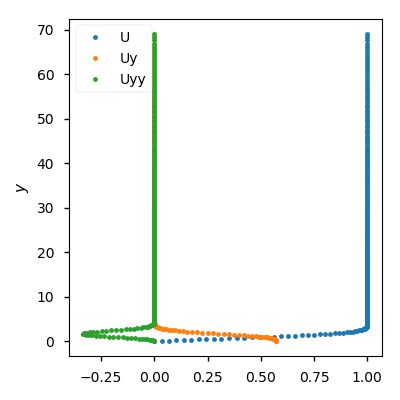

Vinf =  0.0021509845896779895 0.002151


<IPython.core.display.Javascript object>


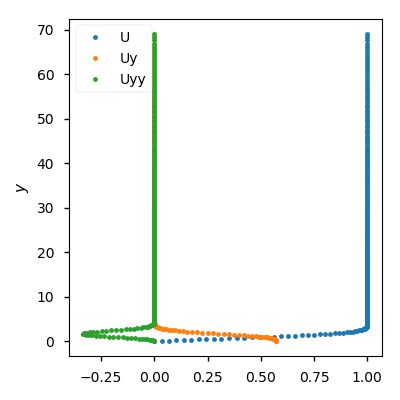

Vinf =  0.0021509845896779895 0.002151


In [28]:
# output case
def output_NALU_inflow(x,y,y_NALU,z,omega,stretch_factor,Ai,eig,evec,U,V,W,filename='OSS_input.txt',output_fluctuations=True):
    U_NALU,V_NALU = base_flow(y_NALU,x=x,Uinf=Uinf,nu=nu,output_full=True,base_type='plate',Dim=2,output_V=True)
    W_NALU = np.zeros_like(U_NALU)
    rest_of_file=np.zeros((y_NALU.size*z.size,9),dtype=np.float64)
    if output_fluctuations:
        ny=y.size
        eig_A_i = np.nanargmin((np.abs(eig-Ai)))
        alpha=eig[eig_A_i]
        print('alpha = ',alpha)
        firstline=([x,y_NALU[0],y_NALU[-1],z[0],z[-1],y_NALU.size,z.size,alpha.real,alpha.imag,omega,stretch_factor])
        u = np.stack([evec[(i*6+0)*ny:(i*6+1)*ny,:] for i,zi in enumerate(z)],axis=-1)[:,eig_A_i]
        v = np.stack([evec[(i*6+2)*ny:(i*6+3)*ny,:] for i,zi in enumerate(z)],axis=-1)[:,eig_A_i]
        w = np.stack([evec[(i*6+4)*ny:(i*6+5)*ny,:] for i,zi in enumerate(z)],axis=-1)[:,eig_A_i]
        print(rest_of_file.shape)
        print(u.shape)
        print(u[:,0]*np.exp(1.j*alpha*x))
        for j in range(y.size):
            for k in range(z.size):
                rest_of_file[k+j*z.size,0] = U[j] # blasius U
                rest_of_file[k+j*z.size,1] = u[j,k].real # fluctuations \hat{u}
                rest_of_file[k+j*z.size,2] = u[j,k].imag # fluctuations \hat{u}
                rest_of_file[k+j*z.size,3] = V[j] # blasius V
                rest_of_file[k+j*z.size,4] = v[j,k].real # fluctuations \hat{v}
                rest_of_file[k+j*z.size,5] = v[j,k].imag # fluctuations \hat{v}
                rest_of_file[k+j*z.size,6] = W[j] # blasius W (zeros)
                rest_of_file[k+j*z.size,7] = w[j,k].real # fluctuations \hat{w}
                rest_of_file[k+j*z.size,8] = w[j,k].imag # fluctuations \hat{w}
        for j in range(y.size,y_NALU.size):
            for k in range(z.size):
                rest_of_file[k+j*z.size,0] = U_NALU[j] # blasius U
                rest_of_file[k+j*z.size,1] = 0 # fluctuations \hat{u}
                rest_of_file[k+j*z.size,2] = 0 # fluctuations \hat{u}
                rest_of_file[k+j*z.size,3] = V_NALU[j] # blasius V
                rest_of_file[k+j*z.size,4] = 0 # fluctuations \hat{v}
                rest_of_file[k+j*z.size,5] = 0 # fluctuations \hat{v}
                rest_of_file[k+j*z.size,6] = W_NALU[j] # blasius W (zeros)
                rest_of_file[k+j*z.size,7] = 0 # fluctuations \hat{w}
                rest_of_file[k+j*z.size,8] = 0 # fluctuations \hat{w}
        fig,ax=plt.subplots(figsize=(3,3))
        ax.plot(u[:,0].real,y,label='real')
        ax.plot(u[:,0].imag,y,label='imag')
        ax.plot(np.abs(u[:,0]),y,label='abs')
        ax.legend(loc='best',frameon=False,numpoints=1)
        ax.set_xlabel(r'$\hat{u}$')
        ax.set_ylabel(r'$y$')
        fig.tight_layout()
        plt.show()
    else:
        firstline=([x,y_NALU[0],y_NALU[-1],z[0],z[-1],y_NALU.size,z.size,0.,0.,0.,stretch_factor])
        for j in range(y_NALU.size):
            for k in range(z.size):
                rest_of_file[k+j*z.size,0] = U_NALU[j] # blasius U
                #rest_of_file[k+j*z.size,1] = 0 # fluctuations \hat{u}
                #rest_of_file[k+j*z.size,2] = 0 # fluctuations \hat{u}
                rest_of_file[k+j*z.size,3] = V_NALU[j] # blasius V
                #rest_of_file[k+j*z.size,4] = 0 # fluctuations \hat{v}
                #rest_of_file[k+j*z.size,5] = 0 # fluctuations \hat{v}
                rest_of_file[k+j*z.size,6] = W_NALU[j] # blasius W (zeros)
                #rest_of_file[k+j*z.size,7] = 0 # fluctuations \hat{w}
                #rest_of_file[k+j*z.size,8] = 0 # fluctuations \hat{w}
    np.savetxt(filename,rest_of_file,header=' '.join(map(str, firstline)),comments='')
Ai=0.17296+0.00510j
U,V = base_flow(y,x=x,Uinf=Uinf,nu=nu,output_full=True,base_type='plate',Dim=2,output_V=True)
#output_NALU_inflow(y,z,omega,stretching_factor,Ai,eig_p1,evec_p1,U,V,np.zeros_like(U)) # outputs all 6 pts in z
#output_NALU_inflow(x,y,y_NALU,z[:2],omega,stretching_factor,Ai,eig_p1,0.0025*evec_p1[:2*6*ny,:],U,V,np.zeros_like(U)) # only output first 2 z pts
output_NALU_inflow(x,y,y_NALU,z[:2],omega,stretching_factor,Ai,0.,0.,U,V,np.zeros_like(U),filename='OSS_input.txt.256y_by_2z',output_fluctuations=False) # only output first 2 z pts

# Run Blasius for all x values and output to NALU wall file

In [24]:
#U,V = base_flow(y_NALU,x=x,Uinf=Uinf,nu=nu,output_full=True,base_type='plate',Dim=2,output_V=True,plot=False)
x_NALU = np.linspace(232.5581395348837,298.8,256) # matches ablmesh.yaml file
#print(V[-1])
#print(x_NALU)
Uinf_NALU=[]
Vinf_NALU=[]
for xi in x_NALU:
    U,V = base_flow(y_NALU,x=xi,Uinf=Uinf,nu=nu,output_full=True,base_type='plate',Dim=2,output_V=True,plot=False)
    Uinf_NALU.append(U[-1])
    Vinf_NALU.append(V[-1])
    print(xi)

Vinf =  0.0021509845896779895 0.002151
232.5581395348837
Vinf =  0.002149784249261838 0.002149799650928297
232.8179115367077
Vinf =  0.002148585916038688 0.0021486013091531965
233.0776835385317
Vinf =  0.0021473895844804623 0.0021474049690863896
233.33745554035568
Vinf =  0.0021461952490809525 0.0021462106251613246
233.59722754217964
Vinf =  0.0021450029043544893 0.0021450182718330962
233.85699954400363
Vinf =  0.0021438125446025845 0.002143827903578341
234.11677154582762
Vinf =  0.0021426241645207734 0.0021426395148951265
234.3765435476516
Vinf =  0.0021414377584070884 0.002141453100302846
234.6363155494756
Vinf =  0.0021402533208822994 0.002140268654342113
234.8960875512996
Vinf =  0.002139070846660787 0.0021390861715746535
235.15585955312358
Vinf =  0.002137890330103774 0.002137905646583205
235.41563155494754
Vinf =  0.002136711765892062 0.002136727073971406
235.67540355677153
Vinf =  0.0021355351486726363 0.0021355504483636994
235.93517555859552
Vinf =  0.002134360473113281 0.00213

Vinf =  0.0020218589699117187 0.0020218734551661183
263.211235750114
Vinf =  0.002020861987555552 0.0020208764656941525
263.471007751938
Vinf =  0.0020198664786930604 0.002019880949621132
263.73077975376196
Vinf =  0.0020188724394731524 0.002018886903321529
263.99055175558595
Vinf =  0.0020178798665266627 0.0020178943231822922
264.25032375740994
Vinf =  0.002016888756008184 0.0020169032056027944
264.51009575923393
Vinf =  0.0020158991044709946 0.0020159135469947744
264.7698677610579
Vinf =  0.0020149109083016778 0.002014925343782284
265.0296397628819
Vinf =  0.002013924164077225 0.0020139385924016345
265.2894117647059
Vinf =  0.0020129388680015714 0.00201295328930134
265.5491837665299
Vinf =  0.002011955016678639 0.002011969430942067
265.8089557683538
Vinf =  0.0020109726065387686 0.002010987013796578
266.0687277701778
Vinf =  0.0020099916342113805 0.0020100060343496815
266.3284997720018
Vinf =  0.0020090120959486996 0.0020090264890981766
266.5882717738258
Vinf =  0.00200803398827974 0

Vinf =  0.0019135051392960803 0.0019135188482128848
293.86433196534426
Vinf =  0.0019126599435467877 0.0019126736464440566
294.12410396716825
Vinf =  0.001911815866851674 0.001911829563664267
294.38387596899224
Vinf =  0.0019109729065997533 0.0019109865974065864
294.64364797081623
Vinf =  0.001910131060474901 0.0019101447452116907
294.9034199726402
Vinf =  0.0019092903258836745 0.0019093040046278345
295.1631919744642
Vinf =  0.0019084507005224492 0.0019084643732108198
295.4229639762882
Vinf =  0.0019076121817837206 0.001907625848523965
295.6827359781122
Vinf =  0.0019067747674406713 0.0019067884281380768
295.9425079799362
Vinf =  0.0019059384548976016 0.00190595210963142
296.20227998176017
Vinf =  0.0019051032418839603 0.0019051168905896874
296.46205198358416
Vinf =  0.0019042691258443325 0.0019042827686059718
296.72182398540815
Vinf =  0.001903436104532932 0.001903449741280737
296.98159598723214
Vinf =  0.0019026041752893423 0.0019026178062217867
297.24136798905613
Vinf =  0.001901773

In [25]:
def output_NALU_top_wall(x_NALU,z,stretch_factor,Uinf_NALU,Vinf_NALU,Winf_NALU,filename='Outflow_input.txt'):
    firstline=([x_NALU[0],x_NALU[-1],z[0],z[-1],x_NALU.size,z.size,stretch_factor])
    rest_of_file=np.zeros((x_NALU.size*z.size,3),dtype=np.float64)
    print(rest_of_file.shape)
    for j in range(x_NALU.size):
        for k in range(z.size):
            rest_of_file[k+j*z.size,0] = Uinf_NALU[j] # blasius U at freestream
            rest_of_file[k+j*z.size,1] = Vinf_NALU[j] # blasius V at freestream
            rest_of_file[k+j*z.size,2] = Winf_NALU[j] # blasius W at freestream
    np.savetxt(filename,rest_of_file,header=' '.join(map(str, firstline)),comments='')
output_NALU_top_wall(x_NALU,z[:2],1.0,Uinf_NALU,Vinf_NALU,np.zeros_like(Uinf_NALU),filename='Outflow_input.txt.256x_by_256y_by_2z') # only output first 2 z pts

(512, 3)
